In [7]:
import numpy as np
import nltk
import math
import string
import os
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
class Similarity:
    def __init__(self, alpha=1.0, beta=1e-3, theta=-1.0):
        self.stemmer = PorterStemmer()
        self.alpha = alpha
        self.beta = beta
        self.theta = theta
        self.item_num = 0

    def change_parameters(self, alpha, beta, theta):
        '''change parameter when doing cross validation'''
        self.alpha = alpha
        self.beta = beta
        self.theta = theta

    def get_parameters(self):
        return self.alpha, self.beta, self.theta

    def read_data(self, dataframe):
        '''read in the data and fill the NaN'''
        # self.data = dataframe
        # self.generate_item_vector()
        # print(self.data.head(3))
        self.data = dataframe
        # self.data['description'].fillna("", inplace=True)
        # self.data['title'].fillna("", inplace=True)
        # self.data['price'].fillna(0, inplace=True)
        self.generate_item_vector()

    def stem_tokens(self, tokens, stemmer):
        '''stemming'''
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed

    def tokenize(self, text):
        '''do stemming for each word'''
        tokens = nltk.word_tokenize(text)
        stems = self.stem_tokens(tokens, self.stemmer)
        return stems

    def data_preprocess(self, corpus):
        ''' stop-word filtering and stemming
            input: every element represent a title/description of an item (after preprocessing)
            corpus = [  
                'This is the first document.',  
                'This is the second second document.',  
                'And the third one.',  
                'Is this the first document?',  
            ]
        '''
        token_lst = []
        for ele in corpus:
            lowers = ele.lower()
            #### delete punctuation in string ####
            table = str.maketrans(dict.fromkeys(string.punctuation))
            no_punctuation = lowers.translate(table)
            token_lst.append(no_punctuation)
        return token_lst


    def cal_tf_idf(self, corpus):
        ''' 
            output: tf-idf value vectors of each element
            tf-idf = [[ 0.          0.43877674  0.54197657  0.43877674  0.          0.			0.35872874  0.          0.43877674]
                      [ 0.          0.27230147  0.          0.27230147  0.          0.85322574	0.22262429  0.          0.27230147]
                      [ 0.55280532  0.          0.          0.          0.55280532  0.			0.28847675  0.55280532  0.        ]
                      [ 0.          0.43877674  0.54197657  0.43877674  0.          0.			0.35872874  0.          0.43877674]]
        '''
        # print self.token_lst
        tfidf = TfidfVectorizer(tokenizer=self.tokenize, stop_words='english')
        tfs = tfidf.fit_transform(corpus)
        return tfs

    def generate_item_vector(self):
        ''' Generate item vector for training data
            item vector: <et, ed, price>
            et: <tf-idf1, tf-idf2, ..., tf-idfk>
            ed: <tf-idf1, tf-idf2, ..., tf-idfk>
            price: normalized price
            self.item_vector_set:
                dict {
                    '0001': {
                        'title': []
                        'description': []
                        'price': float
                    }	
                    '0002': {
                        ...
                    }
                    ...
                }
        '''
        #### original data ####
        price_list = np.array(self.data['price']).tolist()
        number_list = np.array(self.data['asin']).tolist()
        #### tf-idf result ####
        self.title_result = self.cal_tf_idf(self.data_preprocess(np.array(self.data['title']).tolist()))
        '''
        self.title_result:
                v1 v2 v3 ... vn
            v1
            v2
            v3
            ...
            vn 
        '''
        self.title_result = cosine_similarity(self.title_result, self.title_result)
        self.description_result = self.cal_tf_idf(self.data_preprocess(np.array(self.data['description']).tolist()))
        '''
        self.description_result:
                v1 v2 v3 ... vn
            v1
            v2
            v3
            ...
            vn 
        '''
        self.description_result = cosine_similarity(self.description_result, self.description_result)
        #### price result ####
        '''self.price_result: [p1, p2, p3, ... , pn]'''
        self.price_result = [1.0 / (1+math.exp(-self.beta*(price_list[i]))) for i in range(len(price_list))]

        self.item_num = len(price_list)
        self.item_vector_set = {n:{'title':t, 'description':d, 'price':p} for n,t,d,p in zip(number_list, self.title_result, self.description_result, self.price_result)}

    # def generate_item_vector_for_newitem(self, new_item):
    # 	''' Generate item vector for new item
    # 		Input:
    # 			new_item: dataframe
    # 		Output:
    # 			newitem_title_result[0]: list [v1, v2, v3, ....]
    # 			newitem_description_result[0]: list [v1, v2, v3, ....]
    # 			price_result: float
    # 	'''
    # 	#### original data for new item ####
    # 	newitem_title_list = new_item['title']
    # 	newitem_description_list = new_item['description']
    # 	newitem_price_list = new_item['price']
    # 	#### tf-idf result for new item ####
    # 	newitem_title_corpus = self.data_preprocess(newitem_title_list)
    # 	newitem_title_result = self.cal_tf_idf(newitem_title_corpus)
    # 	newitem_description_corpus = self.data_preprocess(newitem_description_list)
    # 	newitem_description_result = self.cal_tf_idf(newitem_description_corpus)
    # 	#### price result for new item ####
    # 	newitem_price_list = new_item['price']
    # 	price_result = 2*(1.0 / (1+math.exp(-self.beta*(newitem_price_list[i]))))-1

    # 	return newitem_title_result[0], newitem_description_result[0], price_result


    # def cal_cos_similarity(self, vec1, vec2):
    # 	'''calculate cosine similarity between two vectors'''
    # 	dot_product = 0.0
    # 	normA = 0.0
    # 	normB = 0.0
    # 	for a, b in zip(vec1, vec2):
    # 		dot_product += a*b
    # 		normA += a**2
    # 		normB += b**2
    # 	if normA == 0.0 or normB == 0.0:
    # 		return 0.0
    # 	else:
    # 		return dot_product / ((normA*normB)**0.5)
    def generate_topk_item_similarity(self, new_asin, k, target_user_list):
            ''' return cosine similarity matrix
            Input:
                k: int value
                new_asin: list
            Output:
                dict{ 
                    new_item1 : {
                        '00001': 3
                        '00002': 2
                        '00003': 1
                    }
                    new_item2 : {
                        '00004': 7
                        '00005': 6
                        '00006': 5
                    }	
                    ...
                }
            '''
            #### get the new&training dataset ####
            '''dict {
                        '0001': 
                            'title': []
                            'description': []
                            'price': float
                        '0002':
                            ...
                    }
            '''
            if k > self.item_num:
                k = self.item_num

            train_item_vec_set = {n:self.data.loc[self.data['asin']==n].index[0] for n in target_user_list if n not in new_asin}
            new_item_vec_set = {n:self.item_vector_set[n] for n in new_asin}

            ret_k_similarities_dict = {}
            for new_key, new_value in new_item_vec_set.items():
                ret_k_similarities = []
                for train_key, train_value in train_item_vec_set.items():
                    value = self.item_vector_set[new_key]['title'][train_value] \
                                + self.alpha*self.item_vector_set[new_key]['description'][train_value] \
                                + self.theta*(np.abs(self.price_result[train_value]-new_value['price']))
                    ret_k_similarities.append([value, train_key])
                ret_k_similarities = sorted(ret_k_similarities, key=lambda x:x[0], reverse=True)
                ret_k_similarities_dict_one = {ret_k_similarities[i][1]:ret_k_similarities[i][0] for i in range(len(ret_k_similarities)) if i <= k-1}
                ret_k_similarities_dict[new_key] = ret_k_similarities_dict_one

            return ret_k_similarities_dict

In [10]:
from scipy import sparse
import pandas as pd

def parse(path):
	g = open(path, 'rb')
	for l in g:
		yield eval(l)

def getDF(path):
	i = 0
	df = {}
	for d in parse(path):
		df[i] = d
		i += 1
	return pd.DataFrame.from_dict(df, orient='index').loc[:, ["title", "description", "price", "asin"]]

def Score(user_num, sim_set, rMatrix):
	sum_sim = 0
	sum_rate = 0
	ratings_of_user = rMatrix[:,user_num].toarray().T.tolist()
	for item_sim in sim_set:
		sum_sim += sim_set[item_sim]
		sum_rate += sim_set[item_sim] * ratings_of_user[0][item_sim]
	return sum_rate/sum_sim

def Probability(score):
	return 1/(1 + math.exp(-score))

# Call CV function

In [11]:
def call_CV(simClass, mfClass, simItem_k, topUser_k, rMatrix_training, item_list, iteration1=10, iteration2=10, steplen_alpha=0.02, steplen_beta=2e-4, steplen_theta=-0.02):

    #### Initial parameters and class ####
    alpha, beta, theta = simClass.get_parameters()

    aggr_output_of_cv = {}
    #### parameter training iteration ####
    for i in range(iteration1):
        print("############################# %dth K-Cross Validation ###############################"%(i))

        #### Modify parameters for each iteration ####
        alpha = alpha + steplen_alpha
        beta = beta + steplen_beta
        theta = theta + steplen_theta
        simClass.change_parameters(alpha, beta, theta)

        start = 0
        end = int(rMatrix_training.shape[0]/iteration2)
        RMSE = []
        #### CV iteration ####
        for j in range(iteration2):
            print("---------- %dth fold of curent CV, %dth Iteration ----------"%(j,i))
            #print("%d-fold> "%j)
            #### Calculate the RMSE for this iteration ####		    
            RMSE.append(active_learning_process(simClass, mfClass, rMatrix_training, simItem_k, topUser_k, item_list, start, end))
            print("RMSE: %f"%RMSE[-1])
            tmp = end
            end = end + (end - start)
            start = tmp


        #### Caculate and record average RMESE for each iteration2 ####
        aggr_output_of_cv[i] = {'avg_RMSE': sum(RMSE)/len(RMSE), 'alpha': alpha, 'beta': beta, 'theta': theta}
        print(aggr_output_of_cv[i])

    #### Find best RMSE and best parameters####
    avg_rmse_lst = [aggr_output_of_cv[i]['avg_RMSE'] for i in aggr_output_of_cv]
    index = avg_rmse_lst.index(max(avg_rmse_lst))

    return aggr_output_of_cv, index

# Active learning function

In [12]:
def active_learning_process(simClass, mfClass, rMatrix, simItem_k, topUser_k, item_list, start, end):

    #### Split training set and validation set ####	
    rating_matrix_expanded = rMatrix.tolil()
    rating_matrix_expanded[start:end,] = 0
    print("rating_martix_expanded_CV DONE")

    #### find k similar items for each new item ####
    newuser_asin = item_list[start:end]		
    print("test interval")
    print(start)
    print(end)
    sims = simClass.generate_topk_item_similarity(newuser_asin, simItem_k, item_list)

    #### construct new-item similarity dictionary ####
    '''
        sims_indexed: {
            'ITEM0001': {
                'ITEM0005': s1
                'ITEM0006': s2
                ...
            }
            'ITEM0002': {
                'ITEM0008': s3
                ...
            }
            ...
        }
    '''
    sims_indexed = {}
    for item in sims:
        sims_indexed[item] = {}
        for item_sim in sims[item]:
            sims_indexed[item][item_list.index(item_sim)] = sims[item][item_sim]
    print("sims_indexed DONE")
    learned_ratings_list = []
    #### Calculate Propability for each new item #### 
    for item in sims_indexed:    
        user_probability = {}
        sim_items_current = ()
        for item_sim in sims_indexed[item]:
            sim_items_current += (item_sim, )
        users_rated_sims = sparse.find(rMatrix[sim_items_current,:])[1]
        users_rated_sims = list(set(users_rated_sims))
        for userNum in users_rated_sims:
            user_probability[userNum] = Probability(Score(userNum, sims_indexed[item],rMatrix )) 
        user_probability = sorted(user_probability.items(), key=lambda d:d[1], reverse = True)

        ### when related users are less than k, randomly fill users into top k users###
        random_fill = True
        if random_fill == True:
            if(topUser_k > len(user_probability)):
                while(len(user_probability) != topUser_k):
                    filler = (int(rMatrix.shape[1] * random.random()), 0)
                    for user_possible in user_probability:
                        if filler[0] == user_possible[0]:
                            filler = (int(rMatrix.shape[1] * random.random()), 0)
                    user_probability.append(filler)

        for top in range(topUser_k):    
            rating_matrix_expanded[item_list.index(item), user_probability[top][0]] = \
                rMatrix[item_list.index(item), user_probability[top][0]]
            learned_ratings_list.append((item_list.index(item), user_probability[top][0]))
    print("item sims ALL DONE")

    ##### Caculate RMSE for each iteration2 #####
    prMatrix = mfClass.MF_gradient_descent(rating_matrix_expanded)
    print("matrix factorization DONE")
    RMSE = mfClass.calculate_average_RMSE(rMatrix, prMatrix, learned_ratings_list, start, end)
    print("rmse DONE")
    return RMSE

# Implementation steps

In [13]:
################################# 2017.10.14 #######################################
''' Step 0: Import Package '''
import pandas as pd
import numpy as np 
import math
import random
from subprocess import check_output
from scipy.sparse import coo_matrix
print(check_output(["ls", "."], shell=True).decode("utf8"))
#import tool_function as tf
#from similarity import Similarity
#from matrix_factorization import MatrixFactorization
####################################################################################

####################################################################################
''' Step 1: Data Input '''
#### Load in ratings data & meta_item data ####
ratingsFrame = pd.read_csv('ratings_Grocery_and_Gourmet_Food.csv')
itemsFrame = getDF('meta_Grocery_and_Gourmet_Food.json')
####################################################################################

####################################################################################
''' Step 2: Data Process '''
#### Fill out all the missing value ####
itemsFrame['description'].fillna("", inplace=True)
itemsFrame['title'].fillna("", inplace=True)
itemsFrame['price'].fillna(0, inplace=True)
#### drop items without any ratings ####
for index, row in itemsFrame.iterrows():
    if row["asin"] not in ratingsFrame.loc[:,"item"].tolist():
        itemsFrame.drop(index, inplace = True)
itemsFrame.reset_index(drop=True, inplace = True)  
itemsFrame = itemsFrame.sample(frac = 1, random_state = 1)
# itemsFrame.head(3)
# ratingsFrame.head(3)
####################################################################################

####################################################################################
''' Step 3: Construct Item Dictionary 
	items: 
		dic {
			'B00001': {
				'User0001': r1
				'User0002': r2
				...
			}
			'B00002': {
				'User0003': r3
				'User0001': r4
			}
			...
		}
'''
items = {}  
for num in range(itemsFrame.shape[0]):
    items[itemsFrame.iloc[num]["asin"]] = {}
for num in range(ratingsFrame.shape[0]):
    if ratingsFrame.iloc[num]["item"] in items:  
        items[ratingsFrame.iloc[num]["item"]][ratingsFrame.iloc[num]["user"]] = ratingsFrame.iloc[num]["rating"]
####################################################################################

####################################################################################
''' Step 4: Construct User-Item Sparse Matrix '''
user_list = []
item_list = []
row = []
col = []
rating_data = []
itemNum = 0
for item in items:
    item_list.append(item)
    for user in items[item]:
        if user not in user_list:
            user_list.append(user)
        row.append(itemNum)
        col.append(user_list.index(user))
        rating_data.append(items[item][user])
    itemNum += 1
rating_martix_coo = coo_matrix((rating_data, (row, col)), shape=(itemsFrame.shape[0], len(user_list)))
rating_martix_csc = rating_martix_coo.tocsc()
rating_martix_csr = rating_martix_coo.tocsr()
####################################################################################

####################################################################################
''' Step 5: Split Dataset into Training and Test'''
start = 0
end = int(rating_martix_csr.shape[0] * 0.7)
rMatrix_training = rating_martix_csr[start:end,]
#rMatrix_test set
####################################################################################

Baseline 2.0.ipynb
Baseline.ipynb
item_metadata
meta_All_Beauty.json
meta_Amazon_Instant_Video.json
meta_Cell_Phones_and_Accessories.json
meta_Computers.json
__pycache__
ratings_Cell_Phones_and_Accessories.csv
ratings_Computers.csv
read_tool.py
Spark test.ipynb
Untitled.ipynb
user_ratings



# CV part

In [15]:
####################################################################################
''' Step 6: Cross Validation '''
simItem_k = 6             # top K similar item to the new item
topUser_k = 3            # top K users to recommender the new item for ratings
K = 20					  # length of user profile and item profile when doing Matrix Factorization
alpha = 1.0
beta = 1e-3
theta = -1.0
simClass = Similarity(alpha, beta, theta)
simClass.read_data(itemsFrame)

############################# 0th K-Cross Validation ###############################
---------- 0th fold of curent CV, 0th Iteration ----------
rating_martix_expanded_CV DONE
test interval
0
298
sims_indexed DONE


/home/zhaozihan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


item sims ALL DONE
MF iterations
0
35664.7637692
10
20
30
40
50
60
70
80
90


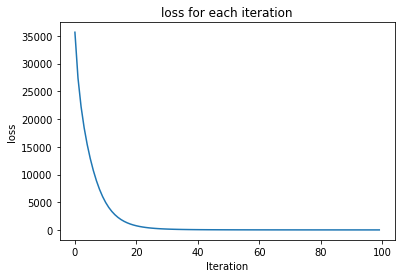

matrix factorization DONE
rmse DONE
RMSE: 1.980118
---------- 1th fold of curent CV, 0th Iteration ----------
rating_martix_expanded_CV DONE
test interval
298
596
sims_indexed DONE


KeyboardInterrupt: 

In [21]:
mfClass = MatrixFactorization(K)
model, optim_ind = call_CV(simClass, mfClass, simItem_k, topUser_k, rMatrix_training, item_list[start:end])
####################################################################################

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt

class MatrixFactorization:
    def __init__(self, K, steps=100, alpha=0.006, beta=0.02, threshold=0.001):
        # self.R = R                                     # user-item matrix
        self.K = K                                     # feature number
        self.steps = steps                             # iterate time
        self.alpha = alpha                             # parameter1
        self.beta = beta                               # parameter2
        self.threshold = threshold                     # error threshold

    def MF_gradient_descent(self, R):
        self.P = np.random.rand(R.shape[1], self.K)         # user latent factor
        self.Q = np.random.rand(R.shape[0], self.K)         # item latent factor 
        print("MF iterations")
        error_list = []
        x = sparse.find(R)
        row = x[0]
        col = x[1]
        for step in range(self.steps):
            for i,j in zip(row, col):
                eij = R[i,j] - np.dot(self.P[j, :], self.Q[i, :].T)
                self.P[j, :] = self.P[j, :] + self.alpha * (2 * eij * self.Q[i, :] - self.beta * self.P[j, :])
                self.Q[i, :] = self.Q[i, :] + self.alpha * (2 * eij * self.P[j, :] - self.beta * self.Q[i, :])
            pR = np.dot(self.Q, self.P.T)
            e = 0
            for i,j in zip(row,col):
                e = e + pow(R[i,j] - pR[i,j], 2)
            for k in range(self.K):       # add regularization
                e = e + (self.beta/2) * (pow(self.P[j][k], 2) + pow(self.Q[i][k], 2))
            error_list.append(e)
            if step % 10 == 0:
                print(step)
                print(e)
            if e < self.threshold:
                break

        #### Plot RMSE picture ####
        plt.figure(1) # 创建图表1
        plt.title('loss for each iteration')
        plt.xlabel('Iteration') 
        plt.ylabel('loss')
        plt.plot(error_list)
        plt.show()

        return np.dot(self.Q, self.P.T)


    def MF_ALS(self, R):
        self.P = np.random.rand(R.shape[1], self.K)         # user latent factor
        self.Q = np.random.rand(R.shape[0], self.K)         # item latent factor 
        print("MF iterations")
        error_list = []        
        x = sparse.find(R)
        row = x[0]                 # item
        col = x[1]                 # user
        for step in range(self.steps):
            print(step)

            #### User Part ####
            denominatorV = 0
            for i in range(R.shape[0]):
                denominatorV = denominatorV + np.dot(self.Q[i, :], self.Q[i, :].T)
            numeratorVR = np.zeros((R.shape[1], self.K))
            for i,j in zip(row, col):
                numeratorVR[j] = numeratorVR[j] + self.Q[i, :]*R[i, j]
            self.P = numeratorVR / denominatorV

            #### Item Part ####
            denominatorU = 0
            for i in range(R.shape[1]):
                denominatorU = denominatorU + np.dot(self.P[i, :], self.P[i, :].T)
            numeratorUR = np.zeros((R.shape[0], self.K))
            for i,j in zip(row, col):
                numeratorUR[i] = numeratorUR[i] + self.P[j, :]*R[i, j]
            self.Q = numeratorUR / denominatorU

            #### Calculate Predicted Matrix ####
            pR = np.dot(self.Q, self.P.T)
            e = 0
            for i,j in zip(row,col):
                e = e + pow(R[i,j] - pR[i,j], 2)
            e = math.sqrt(e/len(row))
            error_list.append(e)

            #### Judge if small than threshold ###
            if e < self.threshold:
                break

        #### Plot RMSE picture ####
        plt.figure(1) # 创建图表1
        plt.title('RMSE for each iteration')
        plt.xlabel('Iteration') 
        plt.ylabel('RMSE value')
        plt.plot(error_list)
        plt.show()

        return np.dot(self.Q, self.P.T)     

    def calculate_average_RMSE(self, oRate, pRate, learned_ratings_list, start, end):
        user_num = oRate.shape[1]
        e = 0
        cnt_of_rate = 0
        
        x = sparse.find(oRate)
        row = x[0]
        col = x[1]
        for i,j in zip(row, col):
            if i not in range(start, end):
                continue
            else:
                if (i,j) not in learned_ratings_list:
                    e = e + pow(oRate[i,j] - pRate[i,j], 2)
                    cnt_of_rate = cnt_of_rate + 1
        return math.sqrt(e/cnt_of_rate)

In [ ]:

####################################################################################
''' Step 7: Use Optimum Parameters on Test Datast''' 
start = int(rating_martix_csr.shape[0] * 0.7)
end = rating_martix_csr.shape[0]
alpha = model[optim_ind]['alpha']
beta = model[optim_ind]['beta']
theta = model[optim_ind]['theta']
simClass.change_parameters(alpha, beta, theta)
tRMSE = active_learning_process(simClass, mfClass, rating_martix_csr, simItem_k, topUser_k, item_list, start, end)
####################################################################################

####################################################################################
''' Step 8: Plot Result of Baseline '''

####################################################################################
